In [17]:
%load_ext autoreload
%autoreload 2

import os, sys
import copy
import socket
from tqdm import tqdm
import torch
import pickle
from torch import optim
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import fl, nn, agg, data, poison, log, sim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Save Logs To File (info | debug | warning | error | critical) [optional]
log.init("debug")
#log.init("info", "federated.log")
#log.init("debug", "flkafka.log")

In [19]:
class FedArgs():
    def __init__(self):
        self.num_clients = 50
        self.epochs = 10
        self.local_rounds = 1
        self.client_batch_size = 32
        self.test_batch_size = 128
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5
        self.cuda = True
        self.seed = 1
        self.tb = SummaryWriter('../../out/runs/federated/FLTrust', comment="Mnist Centralized Federated training")

fedargs = FedArgs()

In [20]:
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [21]:
print(torch.cuda.is_available())

False


In [22]:
host = socket.gethostname()
clients = [host + "(" + str(client + 1) + ")" for client in range(fedargs.num_clients)]

In [23]:
#Initialize Global and Client models
global_model = nn.ModelMNIST()
client_models = {client: copy.deepcopy(global_model) for client in clients}

# Function for training
def train_model(_model, train_loader, fedargs, device):
    model, loss = fl.client_update(_model,
                                train_loader,
                                fedargs.learning_rate,
                                fedargs.weight_decay,
                                fedargs.local_rounds,
                                device)
    model_update = agg.sub_model(_model, model)
    return model_update, model, loss

In [24]:
# Load MNIST Data to clients
train_data, test_data = data.load_dataset("mnist")

In [25]:
# For FLTrust
#############Skip this section for running other averaging
FLTrust = True
root_ratio = 0.01
train_data, root_data = torch.utils.data.random_split(train_data, [int(len(train_data) * (1-root_ratio)), 
                                                              int(len(train_data) * root_ratio)])
root_loader = torch.utils.data.DataLoader(root_data, batch_size=fedargs.client_batch_size, shuffle=True, **kwargs)

#global_model, _ = train_model(global_model, root_loader, fedargs, device)
#client_models = {client: copy.deepcopy(global_model) for client in clients}
#############

In [26]:
clients_data = data.split_data(train_data, clients)

In [27]:
# Poison a client
################Skip this section for running without poison
for client in range(10):
    clients_data[clients[client]] = poison.label_flip(clients_data[clients[client]], 4, 9, poison_percent = -1)
    
#clients_data[clients[0]] = poison.label_flip(clients_data[clients[0]], 6, 2, poison_percent = 1)
#clients_data[clients[0]] = poison.label_flip(clients_data[clients[0]], 3, 8, poison_percent = 1)
#clients_data[clients[0]] = poison.label_flip(clients_data[clients[0]], 1, 5, poison_percent = 1)

In [28]:
client_train_loaders, _ = data.load_client_data(clients_data, fedargs.client_batch_size, None, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=fedargs.test_batch_size, shuffle=True, **kwargs)

clients_info = {
        client: {"train_loader": client_train_loaders[client]}
        for client in clients
    }

In [29]:
B1 = copy.deepcopy(global_model)

C1 = copy.deepcopy(global_model)
C2 = copy.deepcopy(global_model)

C3 = copy.deepcopy(global_model)
C4 = copy.deepcopy(global_model)
C5 = copy.deepcopy(global_model)

#for i in range(3):
_B1, B1, _ = train_model(B1, root_loader, fedargs, device)

_C3, C3, _ = train_model(C3, clients_info[list(clients_info.keys())[21]]['train_loader'], fedargs, device)
_C4, C4, _ = train_model(C4, clients_info[list(clients_info.keys())[22]]['train_loader'], fedargs, device)
_C5, C5, _ = train_model(C5, clients_info[list(clients_info.keys())[23]]['train_loader'], fedargs, device)

In [30]:
#for j in range(20):
_C1, C1, _ = train_model(C1, clients_info[list(clients_info.keys())[1]]['train_loader'], fedargs, device)
_C2, C2, _ = train_model(C2, clients_info[list(clients_info.keys())[2]]['train_loader'], fedargs, device)

print(sim.grad_cosine_similarity(_B1, _C1))
print(sim._grad_cosine_similarity(_B1, _C1))

print("###################################")

print(sim.grad_cosine_similarity(_B1, _C2))
print(sim._grad_cosine_similarity(_B1, _C2))

print("###################################")

print(sim.grad_cosine_similarity(_B1, _C3))
print(sim._grad_cosine_similarity(_B1, _C3))

print("###################################")

print(sim.grad_cosine_similarity(_B1, _C4))
print(sim._grad_cosine_similarity(_B1, _C4))

print("###################################")

print(sim.grad_cosine_similarity(_B1, _C5))
print(sim._grad_cosine_similarity(_B1, _C5))

0.10440989
[array(0.2412346, dtype=float32), array(0.04032703, dtype=float32), array(0.10411308, dtype=float32), array(0.19308697, dtype=float32)]
0.1446904195472598
###################################
0.08757467
[array(0.07569773, dtype=float32), array(0.03305557, dtype=float32), array(0.09019449, dtype=float32), array(0.20181842, dtype=float32)]
0.10019155219197273
###################################
0.52985364
[array(0.56426746, dtype=float32), array(0.53212994, dtype=float32), array(0.5289358, dtype=float32), array(0.55863565, dtype=float32)]
0.5459922105073929
###################################
0.5682737
[array(0.55328256, dtype=float32), array(0.5155681, dtype=float32), array(0.5624943, dtype=float32), array(0.53804237, dtype=float32)]
0.5423468202352524
###################################
0.53900015
[array(0.54823333, dtype=float32), array(0.52675956, dtype=float32), array(0.54156226, dtype=float32), array(0.5195679, dtype=float32)]
0.5340307652950287


In [31]:
'''
def sub_model(model1, model2):
    params1 = model1.state_dict().copy()
    params2 = model2.state_dict().copy()
    
    params1['conv1.weight'] = params2['conv1.weight']
    #params1['fc1.weight'] = params2['fc1.weight']
    
    model = copy.deepcopy(model1)
    model.load_state_dict(params1, strict=False)
    return model

_C1_ = copy.deepcopy(_C1)
_C1_ = sub_model(_B1, _C1_)

_C2_ = copy.deepcopy(_C2)
_C2_ = sub_model(_B1, _C2_)

#print(sim.grad_cosine_similarity(_B1, _C1_))
#print(sim._grad_cosine_similarity(_B1, _C1_))

avgargs = {"base_update": _B1}
t1 = fl.federated_avg({'a': _C1, 'b': _C2, 'c': _C3, 'd': _C4, 'e': _C5}, B1, agg.Rule.FLTrust, **avgargs)
t2 = fl.federated_avg({'a': _C1_, 'b': _C2_, 'c': _C3, 'd': _C4, 'e': _C5}, B1, agg.Rule.FLTrust, **avgargs)

print(fl.eval(t1, test_loader, device))
print(fl.eval(t2, test_loader, device))
'''

'\ndef sub_model(model1, model2):\n    params1 = model1.state_dict().copy()\n    params2 = model2.state_dict().copy()\n    \n    params1[\'conv1.weight\'] = params2[\'conv1.weight\']\n    #params1[\'fc1.weight\'] = params2[\'fc1.weight\']\n    \n    model = copy.deepcopy(model1)\n    model.load_state_dict(params1, strict=False)\n    return model\n\n_C1_ = copy.deepcopy(_C1)\n_C1_ = sub_model(_B1, _C1_)\n\n_C2_ = copy.deepcopy(_C2)\n_C2_ = sub_model(_B1, _C2_)\n\n#print(sim.grad_cosine_similarity(_B1, _C1_))\n#print(sim._grad_cosine_similarity(_B1, _C1_))\n\navgargs = {"base_update": _B1}\nt1 = fl.federated_avg({\'a\': _C1, \'b\': _C2, \'c\': _C3, \'d\': _C4, \'e\': _C5}, B1, agg.Rule.FLTrust, **avgargs)\nt2 = fl.federated_avg({\'a\': _C1_, \'b\': _C2_, \'c\': _C3, \'d\': _C4, \'e\': _C5}, B1, agg.Rule.FLTrust, **avgargs)\n\nprint(fl.eval(t1, test_loader, device))\nprint(fl.eval(t2, test_loader, device))\n'

In [32]:
import numpy as np

from mxnet import nd as mnd

fb1, bslist = sim.get_net_arr(_B1)
fc1, cslist = sim.get_net_arr(_C1)
fc5, cslist = sim.get_net_arr(_C5)
#print(sim.grad_cosine_similarity(_B1, _C1))
#print(sim.grad_cosine_similarity(_B1, _C5))

#print(bslist)

#print(fb1.shape)

cs1 = mnd.dot(mnd.array(fb1), mnd.array(fc1)) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(fc1)) + 1e-9)
cs5 = mnd.dot(mnd.array(fb1), mnd.array(fc5)) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(fc5)) + 1e-9)

#print(cs1, cs5)
_T1 = sim.get_arr_net(_C1, fc1, cslist)
_T5 = sim.get_arr_net(_C5, fc5, cslist)
#print(sim.grad_cosine_similarity(_B1, _T1))
#print(sim.grad_cosine_similarity(_B1, _T5))

ft1, cslist = sim.get_net_arr(_T1)
print(len(np.where(fc1==ft1)[0]))

1199882


1199882
1199882


2021-08-25 12:18:11,234 - matplotlib data path: /home/harsh_1921cs01/anaconda3/envs/syft/lib/python3.9/site-packages/matplotlib/mpl-data [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,242 - CONFIGDIR=/home/harsh_1921cs01/.config/matplotlib [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,245 - matplotlib version 3.4.2 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,245 - interactive is False [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,246 - platform is linux [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,247 - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', '

2021-08-25 12:18:11,287 - CACHEDIR=/home/harsh_1921cs01/.cache/matplotlib [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,289 - Using fontManager instance from /home/harsh_1921cs01/.cache/matplotlib/fontlist-v330.json [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,389 - Loaded backend module://ipykernel.pylab.backend_inline version unknown. [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,391 - Loaded backend module://ipykernel.pylab.backend_inline version unknown. [MainProcess : MainThread (DEBUG)]


80661
647692
0


2021-08-25 12:18:11,668 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,669 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,670 - findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,670 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,671 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,672 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,673 - findfo

2021-08-25 12:18:11,702 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,703 - findfont: score(<Font 'Open Sans' (OpenSans-ExtraBoldItalic.ttf) italic normal 800 normal>) = 11.43 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,704 - findfont: score(<Font 'Overpass' (Overpass-ExtraLight Italic.ttf) italic normal 200 normal>) = 11.24 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,704 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,705 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,705 - findfont: score(<Font 'NanumGothic' (NanumGothicBold.ttf) normal normal 600 normal>) = 10.24 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,7

2021-08-25 12:18:11,731 - findfont: score(<Font 'Open Sans' (OpenSans-ExtraBold.ttf) normal normal 800 normal>) = 10.43 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,732 - findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal 700 normal>) = 10.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,732 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,733 - findfont: score(<Font 'Carlito' (Carlito-BoldItalic.ttf) italic normal 700 normal>) = 11.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,733 - findfont: score(<Font 'Overpass' (Overpass-Bold-Italic.ttf) italic normal 700 normal>) = 11.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,734 - findfont: score(<Font 'FreeMono' (FreeMonoBoldOblique.ttf) oblique normal 700 normal>) = 11.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,734 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bol

0.0021481384


2021-08-25 12:18:11,739 - findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,740 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,740 - findfont: score(<Font 'Open Sans' (OpenSans-Regular.ttf) normal normal 400 normal>) = 10.05 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,741 - findfont: score(<Font 'FreeSerif' (FreeSerifBoldItalic.ttf) italic normal 700 normal>) = 11.335 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,741 - findfont: score(<Font 'FreeMono' (FreeMono.ttf) normal normal 400 normal>) = 10.05 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,742 - findfont: score(<Font 'AR PL UMing CN' (uming.ttc) normal normal 300 normal>) = 10.145 [MainProcess : MainThread (DEBUG)]
2021-08-25 12:18:11,742 - findfont: score(<Font 'Overpass

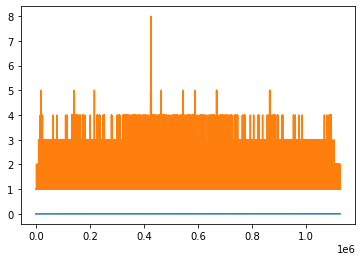

In [33]:
print(len(fc1))
print(np.count_nonzero(fc1))
print(len(np.intersect1d(fb1, fc1)))
print(len(np.where(fc1>fb1-0.0001)[0]))
print(len(np.where(fc1==fb1)[0]))

import matplotlib.pyplot as plt
df1 = fc1 - fb1
unique, counts = np.unique(df1, return_counts=True)
npc = np.asarray((unique, counts)).T
print(np.amax(df1))

plt.plot(npc)
plt.show()

1199882
1199882
104000
650268
1
0.0048349625


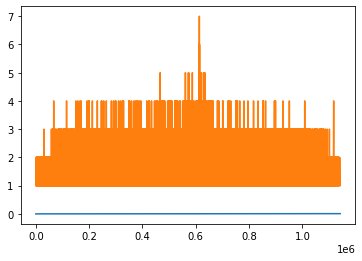

In [34]:
print(len(fc5))
print(np.count_nonzero(fc5))
print(len(np.intersect1d(fb1, fc5)))
print(len(np.where(fc5>fb1-0.0001)[0]))
print(len(np.where(fc5==fb1)[0]))

import matplotlib.pyplot as plt
df5 = fc5 - fb1
unique, counts = np.unique(df5, return_counts=True)
npc = np.asarray((unique, counts)).T
print(np.amax(df5))

plt.plot(npc)
plt.show()

In [35]:
avgargs = {"base_update": _B1}
t1 = fl.federated_avg({'a': _C1, 'b': _C2, 'c': _C3, 'd': _C4, 'e': _C5}, B1, agg.Rule.FLTrust, **avgargs)
print(fl.eval(t1, test_loader, device))

cs5 = mnd.dot(mnd.array(fb1), mnd.array(fc5)) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(fc5)) + 1e-9)
print(cs5)
print(sim.grad_cosine_similarity(_B1, _C5))

np5 = fc5 - fb1
np.random.shuffle(np5)

#V1                       V2
#1, 2, 3, 4.              2, 4, 6, 8
#CS = 1

#np5 = 1, 2, 3, 4
#np5.shuffle = 3, 1, 2, 4

#V3 = 4, 3, 5, 8
#CS = .97

fc11 = fb1 + np5
#fc11 = sim.get_arr_net(_C1, fc11, cslist)
cs11 = mnd.dot(mnd.array(fb1), mnd.array(fc11)) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(fc11)) + 1e-9)
print(cs11)

fc11 = sim.get_arr_net(_C1, fc11, cslist)
print(sim.grad_cosine_similarity(_B1, fc11))

np.random.shuffle(np5)

fc22 = fb1 + np5
#fc11 = sim.get_arr_net(_C1, fc11, cslist)
cs22 = mnd.dot(mnd.array(fb1), mnd.array(fc22)) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(fc22)) + 1e-9)
print(cs22)

fc22 = sim.get_arr_net(_C2, fc22, cslist)
print(sim.grad_cosine_similarity(_B1, fc22))

t1 = fl.federated_avg({'a': fc11, 'b': fc22, 'c': _C3, 'd': _C4, 'e': _C5}, B1, agg.Rule.FLTrust, **avgargs)
print(fl.eval(t1, test_loader, device))

/home/harsh_1921cs01/hub/F3IA/fl/libs/sim.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _param_list = nd.array(param_list).squeeze()
2021-08-25 12:18:13,561 - /home/harsh_1921cs01/hub/F3IA/fl/libs/agg.py::FLTrust(l:90) : FLTrust Score [0.104, 0.088, 0.53, 0.568, 0.539] [MainProcess : MainThread (INFO)]


{'test_loss': 1.5952618795394897, 'correct': 6643, 'accuracy': 66.43}

[0.53900015]
<NDArray 1 @cpu(0)>
0.53900015

[0.5752506]
<NDArray 1 @cpu(0)>
0.5752506

[0.5763362]
<NDArray 1 @cpu(0)>
0.5763362


2021-08-25 12:18:20,522 - /home/harsh_1921cs01/hub/F3IA/fl/libs/agg.py::FLTrust(l:90) : FLTrust Score [0.575, 0.576, 0.53, 0.568, 0.539] [MainProcess : MainThread (INFO)]


{'test_loss': 1.6542307916641235, 'correct': 6123, 'accuracy': 61.23}


In [36]:
'''
model=nn.denoising_model().to(device)
criterion=torch.nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.5,weight_decay=1e-5)

output = fc1
model.train()
for epcoh in range(10):
    optimizer.zero_grad()
    output = model(torch.from_numpy(fc1))
    cs1 = mnd.dot(mnd.array(fb1), mnd.array(output.detach().numpy())) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(output.detach().numpy())) + 1e-9)
    _loss = criterion(output, torch.from_numpy(fb1))
    _loss = _loss + (1 - cs1.asnumpy()[0])
    print(_loss)
    _loss.backward()
    optimizer.step()
'''

'\nmodel=nn.denoising_model().to(device)\ncriterion=torch.nn.MSELoss()\noptimizer=optim.SGD(model.parameters(),lr=0.5,weight_decay=1e-5)\n\noutput = fc1\nmodel.train()\nfor epcoh in range(10):\n    optimizer.zero_grad()\n    output = model(torch.from_numpy(fc1))\n    cs1 = mnd.dot(mnd.array(fb1), mnd.array(output.detach().numpy())) / (mnd.norm(mnd.array(fb1)) + 1e-9) / (mnd.norm(mnd.array(output.detach().numpy())) + 1e-9)\n    _loss = criterion(output, torch.from_numpy(fb1))\n    _loss = _loss + (1 - cs1.asnumpy()[0])\n    print(_loss)\n    _loss.backward()\n    optimizer.step()\n'